In [50]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange
from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
class TwoMoonsDataset(torch.utils.data.Dataset):
    """
    Dataset where targets only depend on one of the input dimensions
    We want to ensure we capture uncertainty when deviating even in the insensitive direction
    """
    def __init__(self, N=200, noise=0.2, split='train') -> None:
        super().__init__()
        if split=='train':
            random_state = 1
        elif split == 'val':
            random_state = 2
        else:
            random_state = 3
        X,y = make_moons(n_samples=N, shuffle=True, noise=noise, random_state=random_state)
        self.X = torch.from_numpy(X).float() #+ 5*torch.ones(2)
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx])

In [52]:
# DNN mapping 2d input to 1d distribution parameter
model = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)

model[0].requires_grad = False

# create function turning theta (the output of the network) into a distribution object
dist_constructor = lambda theta: scod.distributions.Categorical(logits=theta)

### model training

mean_loss=0.110726: 100%|██████████| 200/200 [00:06<00:00, 31.54it/s]


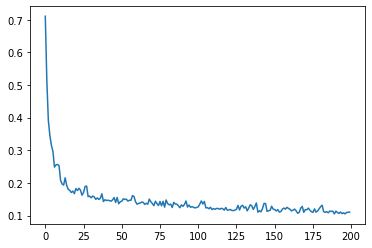

In [53]:
dataset = TwoMoonsDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)
        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 1e3

        total_loss = mean_loss + regularization
        total_loss.backward()

        epoch_loss += total_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [54]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

<class 'scod.sketching.sketched_pca.SRFT_SinglePassPCA'>


### process training dataset to compute posterior uncertainty

In [55]:
unc_model.process_dataset(dataset)

  3%|▎         | 6/200 [00:00<00:03, 56.96it/s]

computing basis
using T = 304


100%|██████████| 200/200 [00:03<00:00, 51.52it/s]


### use validation dataset to optimize prior variance

In [57]:
val_dataset = TwoMoonsDataset(split='val')
unc_model.optimize_prior_scale_by_nll(val_dataset, num_epochs=10)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s, eps=0.281]


### compare SCOD's predictions to the original trained model

In [58]:
X1,X2 = np.meshgrid( np.linspace(-5.,5.,50), np.linspace(-5.,5.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = torch.softmax( model(xx_tensor), -1)
yhat = yhat[:,1].detach().cpu().numpy()

dists, uncs = unc_model(xx_tensor)
scod_yhat = np.array([ y.probs[1].detach().cpu().numpy() for y in dists])
uncs = uncs.detach().cpu().numpy()

100%|██████████| 200/200 [00:03<00:00, 54.58it/s, batch_loss=0.0253, eps=0.281] 


Text(0.5, 1.0, 'SCOD uncertainty')

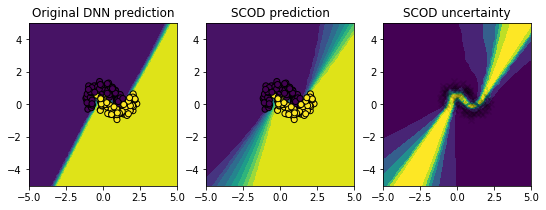

In [59]:
fig, axes = plt.subplots(1,3, figsize=[9,3])
axes[0].contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=0., vmax=1.)
axes[0].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=0, vmax=1, edgecolors='k')
axes[0].set_title('Original DNN prediction')
axes[1].contourf(X1,X2,scod_yhat.reshape(X1.shape), levels=10, vmin=0., vmax=1.)
axes[1].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=0, vmax=1, edgecolors='k')
axes[1].set_title('SCOD prediction')
axes[2].contourf(X1,X2,uncs.reshape(X1.shape), extend="both")
axes[2].scatter(dataset.X[:,0], dataset.X[:,1], marker='x', facecolor='k', alpha=0.1)
axes[2].set_title('SCOD uncertainty')
